# 08. PyTorch Experiment Tracking Exercises

Welcome to the 08. PyTorch Paper Replicating exercises.

Your objective is to write code to satisify each of the exercises below.

Some starter code has been provided to make sure you have all the resources you need.

> **Note:** There may be more than one solution to each of the exercises.

## Resources

1. These exercises/solutions are based on [section 08. PyTorch Paper Replicating](https://www.learnpytorch.io/08_pytorch_paper_replicating/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/tjpW_BY8y3g) (but try the exercises yourself first!).
3. See [all solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

> **Note:** The first section of this notebook is dedicated to getting various helper functions and datasets used for the exercises. The exercises start at the heading "Exercise 1: ...".

### Get various imports and helper functions

The code in the following cells prepares imports and data for the exercises below. They are taken from [08. PyTorch Paper Replicating](https://www.learnpytorch.io/08_pytorch_paper_replicating/).

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")


[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/nightly/cu113
torch version: 2.5.1+cu121
torchvision version: 0.20.1+cu121


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4356, done.
remote: Counting objects: 100% (185/185), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 4356 (delta 154), reused 119 (delta 119), pack-reused 4171 (from 3)
Receiving objects: 100% (4356/4356), 654.37 MiB | 40.34 MiB/s, done.
Resolving deltas: 100% (2583/2583), done.
Updating files: 100% (248/248), done.


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Get data

Want to download the data we've been using in PyTorch Paper Replicating: https://www.learnpytorch.io/08_pytorch_paper_replicating/#1-get-data

In [4]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [5]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

### Preprocess data

Turn images into tensors using same code as PyTorch Paper Replicating section 2.1 and 2.2: https://www.learnpytorch.io/08_pytorch_paper_replicating/#21-prepare-transforms-for-images

In [6]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [7]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7fd06ac60190>,
 ['pizza', 'steak', 'sushi'])

In [8]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

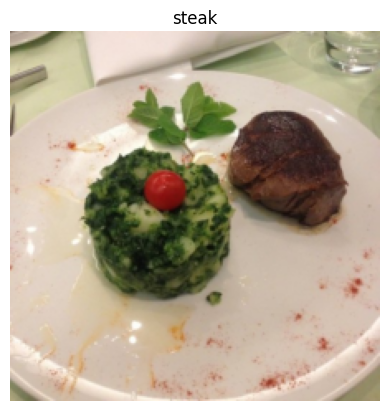

In [9]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

## 1. Replicate the ViT architecture we created with in-built [PyTorch transformer layers](https://pytorch.org/docs/stable/nn.html#transformer-layers).

* You'll want to look into replacing our `TransformerEncoderBlock()` class with [`torch.nn.TransformerEncoderLayer()`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html#torch.nn.TransformerEncoderLayer) (these contain the same layers as our custom blocks).
* You can stack `torch.nn.TransformerEncoderLayer()`'s on top of each other with [`torch.nn.TransformerEncoder()`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html#torch.nn.TransformerEncoder).

In [10]:
transformer_encoder_layer = nn.TransformerEncoderLayer(
    d_model=768,
    nhead=12,
    dim_feedforward=3072,
    dropout=0.1,
    activation="gelu",
    batch_first=True,
    norm_first=True
    )
transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [11]:
transformer_encoder = nn.TransformerEncoder(encoder_layer=transformer_encoder_layer, num_layers=12)
transformer_encoder

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


TransformerEncoder(
  (layers): ModuleList(
    (0-11): 12 x TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
      )
      (linear1): Linear(in_features=768, out_features=3072, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=3072, out_features=768, bias=True)
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
  )
)

In [12]:
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
  """Turns a 2D input image into a 1D sequence learnable embedding vector.

  Args:
      in_channels (int): Number of color channels for the input images. Defaults to 3.
      patch_size (int): Size of patches to convert input image into. Defaults to 16.
      embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
  """
  # 2. Initialize the class with appropriate variables
  def __init__(self,
                in_channels:int=3,
                patch_size:int=16,
                embedding_dim:int=768):
    super().__init__()

    # 3. Create a layer to turn an image into patches
    self.patcher = nn.Conv2d(in_channels=in_channels,
                              out_channels=embedding_dim,
                              kernel_size=patch_size,
                              stride=patch_size,
                              padding=0)

    # 4. Create a layer to flatten the patch feature maps into a single dimension
    self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                              end_dim=3)

    self.patch_size = patch_size

  # 5. Define the forward method
  def forward(self, x):
    # Create assertion to check that inputs are the correct shape
    image_resolution = x.shape[-1]

    assert image_resolution % self.patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"

    # Perform the forward pass
    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)
    # 6. Make sure the output shape has the right order
    return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

In [13]:
class PyTorchViT(nn.Module):
  """Creates a Vision Transformer architecture (with PyTorch layers) with ViT-Base hyperparameters by default."""
  #initilize with parameters in table 1 and 3
  def __init__(self,
               img_size:int=224, # height and width of the images
               in_channels:int=3, # 3 color channels
               patch_size:int=16,
               num_transformer_layer:int=12, # from table 1
               embedding_dim:int=768, # Hidden size in table 1
               mlp_size:int=3072, # from table 1
               num_heads:int=12, # from table 1
               attn_dropout:float=0,
               mlp_dropout:float=0.1,
               embedding_droupout:float=0.1,
               num_classes:int=1000, # for ImageNet dataset
               ):
    super().__init__()

    # make sure the image size is divisble by the patch size
    assert img_size % patch_size == 0, f"Image size must be divisble by patch size, image size: {img_size}, patch size: {patch_size}"

    # num of patches = N in the ViT paper
    self.num_Patches = (img_size * img_size) // patch_size**2

    # class embedding
    self.class_embedding = nn.Parameter(data=torch.randn(1,1,embedding_dim),
                                        requires_grad=True)

    # position embedding
    self.position_embedding = nn.Parameter(data=torch.randn(1,self.num_Patches+1,embedding_dim),
                                           requires_grad=True)

    # embedding dropout
    self.embedding_droupout = nn.Dropout(p=embedding_droupout)

    # patch embedding layer
    self.patch_embedding = PatchEmbedding(
        in_channels=3,
        patch_size=16,
        embedding_dim=768
    )

    # use the predefined transformer_encoder (constructed from PyTorch layers)
    self.transformer_encoder = transformer_encoder

    # classifier head
    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim,
                  out_features=num_classes)
    )

  def forward(self, x):

    # batch size
    batch_size = x.shape[0]

    ### Equation 1 ###
    # creae class token that is expanded to the batch size
    class_token = self.class_embedding.expand(batch_size, -1, -1)

    # create patch embedding
    x = self.patch_embedding(x)

    # concat class embedding
    x = torch.cat((class_token, x), dim=1)

    # add posistion embedding
    x = self.position_embedding + x

    ### end Equation 1 ###

    # run embedding dropout
    x = self.embedding_droupout(x)

    ## Equation 2 and 3 ###

    # pass embeddings into transformer encoder
    x = self.transformer_encoder(x)

    ### end Equatino 2 and 3 ###

    ### Equation 4 ###

    x = self.classifier(x[:,0])

    ### Equation 4 ###

    return x

- Test and see the model

In [14]:
# test PyTorchViT class
set_seeds()

# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224).to(device) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
pyTorchVit = PyTorchViT(num_classes=len(class_names)).to(device)

# Pass the random image tensor to our ViT instance
pyTorchVit(random_image_tensor)

tensor([[ 1.0929, -0.2832,  0.6432]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [15]:
# Print a summary of PyTorchViT model using torchinfo
summary(model=pyTorchVit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
PyTorchViT (PyTorchViT)                                 [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedding (patch_embedding)                      [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                 [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_droupout)                          [32, 197, 768]       [32, 197, 768]       --                   --
├─TransformerEncoder (transformer_encoder)              [32, 197, 768]       [32, 197, 768]       --                   True
│    └─ModuleList (layers)                              --                   --                   --                   True
│    │ 

- Train the model

In [16]:
# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper
optimizer = torch.optim.Adam(params=pyTorchVit.parameters(),
                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
set_seeds()

# Train the model and save the training results to a dictionary
results = engine.train(model=pyTorchVit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.7592 | train_acc: 0.2539 | test_loss: 4.4517 | test_acc: 0.2604
Epoch: 2 | train_loss: 2.2596 | train_acc: 0.4258 | test_loss: 1.7754 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.2275 | train_acc: 0.3086 | test_loss: 1.3424 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.2050 | train_acc: 0.2617 | test_loss: 1.4706 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.1444 | train_acc: 0.3008 | test_loss: 1.3918 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.1687 | train_acc: 0.2695 | test_loss: 1.4059 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.2144 | train_acc: 0.2852 | test_loss: 1.3896 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.1244 | train_acc: 0.2852 | test_loss: 1.2402 | test_acc: 0.2604
Epoch: 9 | train_loss: 1.1523 | train_acc: 0.4297 | test_loss: 1.0246 | test_acc: 0.5417
Epoch: 10 | train_loss: 1.2674 | train_acc: 0.2422 | test_loss: 1.4606 | test_acc: 0.2604


## 2. Turn the custom ViT architecture we created into a Python script, for example, `vit.py`.

* You should be able to import an entire ViT model using something like`from vit import ViT`.
* We covered the art of turning code cells into Python scrips in [05. PyTorch Going Modular](https://www.learnpytorch.io/05_pytorch_going_modular/).


In [17]:
%%writefile going_modular/vit.py

import torch

from torch import nn

transformer_encoder_layer = nn.TransformerEncoderLayer(
    d_model=768,
    nhead=12,
    dim_feedforward=3072,
    dropout=0.1,
    activation="gelu",
    batch_first=True,
    norm_first=True
    )

transformer_encoder = nn.TransformerEncoder(encoder_layer=transformer_encoder_layer, num_layers=12)

# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
  """Turns a 2D input image into a 1D sequence learnable embedding vector.

  Args:
      in_channels (int): Number of color channels for the input images. Defaults to 3.
      patch_size (int): Size of patches to convert input image into. Defaults to 16.
      embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
  """
  # 2. Initialize the class with appropriate variables
  def __init__(self,
                in_channels:int=3,
                patch_size:int=16,
                embedding_dim:int=768):
    super().__init__()

    # 3. Create a layer to turn an image into patches
    self.patcher = nn.Conv2d(in_channels=in_channels,
                              out_channels=embedding_dim,
                              kernel_size=patch_size,
                              stride=patch_size,
                              padding=0)

    # 4. Create a layer to flatten the patch feature maps into a single dimension
    self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                              end_dim=3)

    self.patch_size = patch_size

  # 5. Define the forward method
  def forward(self, x):
    # Create assertion to check that inputs are the correct shape
    image_resolution = x.shape[-1]

    assert image_resolution % self.patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"

    # Perform the forward pass
    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)
    # 6. Make sure the output shape has the right order
    return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

class PyTorchViT(nn.Module):
  """Creates a Vision Transformer architecture (with PyTorch layers) with ViT-Base hyperparameters by default."""
  #initilize with parameters in table 1 and 3
  def __init__(self,
               img_size:int=224, # height and width of the images
               in_channels:int=3, # 3 color channels
               patch_size:int=16,
               num_transformer_layer:int=12, # from table 1
               embedding_dim:int=768, # Hidden size in table 1
               mlp_size:int=3072, # from table 1
               num_heads:int=12, # from table 1
               attn_dropout:float=0,
               mlp_dropout:float=0.1,
               embedding_droupout:float=0.1,
               num_classes:int=1000, # for ImageNet dataset
               ):
    super().__init__()

    # make sure the image size is divisble by the patch size
    assert img_size % patch_size == 0, f"Image size must be divisble by patch size, image size: {img_size}, patch size: {patch_size}"

    # num of patches = N in the ViT paper
    self.num_Patches = (img_size * img_size) // patch_size**2

    # class embedding
    self.class_embedding = nn.Parameter(data=torch.randn(1,1,embedding_dim),
                                        requires_grad=True)

    # position embedding
    self.position_embedding = nn.Parameter(data=torch.randn(1,self.num_Patches+1,embedding_dim),
                                           requires_grad=True)

    # embedding dropout
    self.embedding_droupout = nn.Dropout(p=embedding_droupout)

    # patch embedding layer
    self.patch_embedding = PatchEmbedding(
        in_channels=3,
        patch_size=16,
        embedding_dim=768
    )

    # use the predefined transformer_encoder (constructed from PyTorch layers)
    self.transformer_encoder = transformer_encoder

    # classifier head
    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim,
                  out_features=num_classes)
    )

  def forward(self, x):

    # batch size
    batch_size = x.shape[0]

    ### Equation 1 ###
    # creae class token that is expanded to the batch size
    class_token = self.class_embedding.expand(batch_size, -1, -1)

    # create patch embedding
    x = self.patch_embedding(x)

    # concat class embedding
    x = torch.cat((class_token, x), dim=1)

    # add posistion embedding
    x = self.position_embedding + x

    ### end Equation 1 ###

    # run embedding dropout
    x = self.embedding_droupout(x)

    ## Equation 2 and 3 ###

    # pass embeddings into transformer encoder
    x = self.transformer_encoder(x)

    ### end Equatino 2 and 3 ###

    ### Equation 4 ###

    x = self.classifier(x[:,0])

    ### Equation 4 ###

    return x

Writing going_modular/vit.py


- Test importing the model from the vit script

In [18]:
from going_modular import vit

model = vit.PyTorchViT()

model

PyTorchViT(
  (embedding_droupout): Dropout(p=0.1, inplace=False)
  (patch_embedding): PatchEmbedding(
    (patcher): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (flatten): Flatten(start_dim=2, end_dim=3)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-11): 12 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (linear1): Linear(in_features=768, out_features=3072, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=3072, out_features=768, bias=True)
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (classifier): Sequential(
    (0): LayerNorm((768,), e

## 3. Train a pretrained ViT feature extractor model (like the one we made in [08. PyTorch Paper Replicating section 10](https://www.learnpytorch.io/08_pytorch_paper_replicating/#10-bring-in-pretrained-vit-from-torchvisionmodels-on-same-dataset)) on 20% of the pizza, steak and sushi data like the dataset we used in [07. PyTorch Experiment Tracking section 7.3](https://www.learnpytorch.io/07_pytorch_experiment_tracking/#73-download-different-datasets)
* See how it performs compared to the EffNetB2 model we compared it to in [08. PyTorch Paper Replicating section 10.6](https://www.learnpytorch.io/08_pytorch_paper_replicating/#106-save-feature-extractor-vit-model-and-check-file-size).

In [19]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # "DEFAULT" means best available

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

pretrained_vit

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 179MB/s]


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [20]:
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [21]:
# Download pizza, steak, sushi images from GitHub (20 percent)
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")
image_path

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi_20_percent')

In [22]:
# Setup (new) train and test directory paths
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

In [23]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [24]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32)


In [25]:
# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7020 | train_acc: 0.7521 | test_loss: 0.2714 | test_acc: 0.9381
Epoch: 2 | train_loss: 0.2532 | train_acc: 0.9062 | test_loss: 0.1672 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1764 | train_acc: 0.9542 | test_loss: 0.1273 | test_acc: 0.9693
Epoch: 4 | train_loss: 0.1276 | train_acc: 0.9625 | test_loss: 0.1074 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1159 | train_acc: 0.9646 | test_loss: 0.0953 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.1274 | train_acc: 0.9375 | test_loss: 0.0832 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0897 | train_acc: 0.9771 | test_loss: 0.0845 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0919 | train_acc: 0.9812 | test_loss: 0.0764 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0922 | train_acc: 0.9792 | test_loss: 0.0734 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0658 | train_acc: 0.9833 | test_loss: 0.0644 | test_acc: 0.9847


## 4. Try repeating the steps from excercise 3 but this time use the "`ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1`" pretrained weights from [`torchvision.models.vit_b_16()`](https://pytorch.org/vision/stable/models/generated/torchvision.models.vit_b_16.html#torchvision.models.vit_b_16).
* Note: ViT pretrained with SWAG weights has a minimum input image size of (384, 384), though this is accessible in the weights `.transforms()` method.

In [ ]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_swag_weights = torchvision.models.ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1 # "DEFAULT" means best available

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit_swag = torchvision.models.vit_b_16(weights=pretrained_vit_swag_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit_swag.parameters():
    parameter.requires_grad = False

# 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
set_seeds()
pretrained_vit_swag.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

pretrained_vit_swag

In [ ]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_swag_transforms = pretrained_vit_swag_weights.transforms()
print(pretrained_vit_swag_transforms)

In [ ]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_swag_transforms,
                                                                                                     batch_size=32)


In [29]:
# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit_swag.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_swag_results = engine.train(model=pretrained_vit_swag,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4469 | train_acc: 0.9000 | test_loss: 0.0269 | test_acc: 1.0000
Epoch: 2 | train_loss: 0.0490 | train_acc: 0.9854 | test_loss: 0.0183 | test_acc: 1.0000
Epoch: 3 | train_loss: 0.0299 | train_acc: 0.9896 | test_loss: 0.0105 | test_acc: 1.0000
Epoch: 4 | train_loss: 0.0206 | train_acc: 0.9979 | test_loss: 0.0067 | test_acc: 1.0000
Epoch: 5 | train_loss: 0.0156 | train_acc: 1.0000 | test_loss: 0.0058 | test_acc: 1.0000
Epoch: 6 | train_loss: 0.0128 | train_acc: 1.0000 | test_loss: 0.0049 | test_acc: 1.0000
Epoch: 7 | train_loss: 0.0103 | train_acc: 1.0000 | test_loss: 0.0042 | test_acc: 1.0000
Epoch: 8 | train_loss: 0.0123 | train_acc: 1.0000 | test_loss: 0.0040 | test_acc: 1.0000
Epoch: 9 | train_loss: 0.0081 | train_acc: 1.0000 | test_loss: 0.0052 | test_acc: 1.0000
Epoch: 10 | train_loss: 0.0078 | train_acc: 1.0000 | test_loss: 0.0035 | test_acc: 1.0000


# 5. Our custom ViT model architecture closely mimics that of the ViT paper, however, our training recipe misses a few things.
* Research some of the following topics from Table 3 in the ViT paper that we miss and write a sentence about each and how it might help with training:
    * **ImageNet-21k pretraining**
      - ImageNet-21k data set is
        - a data set with 21000 classes
        - 14 million images
      - pretraining a model on ImageNet-21k first would
        - make the model learn useful patterns
        - make the model generilze better
      - then the model would be fine tuned on specific dataset
    * **Learning rate warmup**
      - start with a small learning rate and gradually increase it with epochs increasing
      - starting small and not big, prevent the model from taking large steps, which would make the model learning more stable
    * **Learning rate decay**
      - in cotrast to learning rate warmup, learning rate decay would start with a big learning rate then make it smaller
      - it follows the theory of big learning rate makes the model learn better and faster, and smaller learning rate (in the later phases of the trainig) is better for fine tuning
    * **Gradient clipping**
      - to solve the problem of exploding gradient (gradients becoming too big)